   # Vaccination rate in schools - where can we improve?
   
   <img src=vaccine.jpg width="900">
   
   **Credit:**  [healthline](https://www.healthline.com/health-news/vaccinations-before-new-school-year) 

In [1]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings

sns.set(style='ticks')

warnings.filterwarnings("ignore")  # Suppress all warnings

# Introduction

**Business Context:** The U.S. had its worst year for measles in 25 years in the first half of 2019, with most cases occurring in confined pockets of unvaccinated people. In order to get a better sense of immunization rates at the local level, The Wall Street Journal compiled kindergarten rates for individual schools across the country by reaching out to state health departments.

Some states also didn’t provide school-level data. A few states track their immunization rates by sampling schools in coordination with the Centers for Disease Control and Prevention and don’t collect data for all schools. Others didn’t publish school-level data due to small class sizes, and a handful of states only collect vaccination exemption forms for the state or county. Most schools have relatively high MMR vaccination rates of 90% or above. But many schools have rates in the 70% to 80% range, and some small, private schools have rates hovering around 50%.

**Methodology:** Addresses for about 16,000 schools in eight states were provided with the vaccination data by the state health departments. The remaining schools were checked against the National Center for Education Statistics’s school directory or that states’ school directory using school name, city, county and/or school district. If there was no unique match, the school’s location was determined with Google Maps API using school name, state and county, city and/or school district. Duplicate locations were analyzed individually. Schools with only state, school name and no additional identifying information are not displayed on the map.


**Analytics Context:** Reporters at the Wall Street Journal collected data on school-specific vaccination rates. In total, the WSJ’s dataset covers more than 46,000 schools, of which 42,000 have at least one vaccination rate available. Most states provided data for the 2018–19 school year. 

To make it more interesting datasets were added containing poverty by district, median household income per district, political party preference per district, and level of education per state representing the percentage of high school graduates or higher.

**Problem Identification:** Many schools across the US have vaccination rate below the >= 95% recommended by the CDC. I am interested in understanding where these schools are, what the demographics look like around those areas, and if there are any predictors of where vaccination rates might fall in the future. If we can identify these characteristics, we can make recommendations based on that and increase vaccination compliance across the US.

**Questions:** 
1. What are the states with higher and lower vaccination rates? 
2. Does socioeconomic status play any role in vaccination rate?
3. Does education level have any relationship to vaccination rate in schools? 
4. What are the variables that seem to impact vaccination rate the most?
5. Does political party help to predict vaccination rate?
6. Which variables are most correlated with vaccination rate?

**Goal**: Create a model to predict vaccination compliance at schools in the United States.


_Sources: Wall Street Journal, State education and health departments; National Center for Education Statistics; Google Maps (geocoding); Centers for Disease Control and Prevention (state-level rates, measles cases)_


# Data Wrangling

The process of transforming and mapping data from one "raw" data form into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes such as analytics.

## Extracting and cleaning relevant data

Let's start looking at the datasets!

**1. Vaccination Dataset:**

Contains vaccination rate from schools per county. The columns are: state, year, county, enrollment per county, mmr and overall vaccination rate, and three columns with rate for distinct exemption reason.

In [2]:
# vaccination datset containing vaccination rate for schools by county/district
vaccine_df = pd.read_csv('state-overviews.csv', index_col=0)
vaccine_df = vaccine_df.sort_values(by=['state','county/district'], ascending=True)
vaccine_df.head()


,state,year,county/district,enroll,mmr,overall,xmed,xper,xrel
index,,,,,,,,,
1,Alabama,2017-18,Autauga,1817,64.17,96.39,0.04,NaN,0.57
2,Alabama,2017-18,Baldwin,5479,70.89,96.53,0.09,NaN,1.15
3,Alabama,2017-18,Barbour,733,72.17,88.27,0.05,NaN,0.13
4,Alabama,2017-18,Bibb,538,66.54,94.54,0,NaN,0.54
5,Alabama,2017-18,Blount,1450,70.69,97.3,0,NaN,0.46


In [3]:
# updating state long name to abbreviation version
# creating dictionary mapping full name to abbreviation
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

vaccine_df['state'] = vaccine_df['state'].map(us_state_abbrev) # updating long state name to abbreviation
vaccine_df.rename(columns={'county/district': 'district name'}, inplace=True) # renaming column
vaccine_df

,state,year,district name,enroll,mmr,overall,xmed,xper,xrel
index,,,,,,,,,
1,AL,2017-18,Autauga,1817,64.17,96.39,0.04,NaN,0.57
2,AL,2017-18,Baldwin,5479,70.89,96.53,0.09,NaN,1.15
3,AL,2017-18,Barbour,733,72.17,88.27,0.05,NaN,0.13
4,AL,2017-18,Bibb,538,66.54,94.54,0,NaN,0.54
5,AL,2017-18,Blount,1450,70.69,97.3,0,NaN,0.46
...,...,...,...,...,...,...,...,...,...
19,WY,2018-19,Sweetwater,616,80.00,75,NaN,NaN,NaN
20,WY,2018-19,Teton,218,72.00,65,NaN,NaN,NaN
21,WY,2018-19,Uinta,348,72.00,64,NaN,NaN,NaN


In [4]:
# Creating a dictionary with all of the counties per state present in vaccination dataset in order to generate the merge
counties_for_state = {}

for state in vaccine_df['state'].unique():
    counties_in_state = vaccine_df[vaccine_df['state'] == state]['district name'].values.tolist()
    counties_for_state[state] = [x for x in counties_in_state]

# Add empty list for states not represented in the poverty dataset
for state in ['AK', 'AR', 'DE', 'DC', 'GA', 'HI', 'ID', 'IL', 'MO', 'MS', 'NH', 'PR', 'VA', 'WV']:
    counties_for_state[state] = []

#counties_for_state

------------------

**2. Poverty Dataset:**

Contains estimated number of relevant children 5 to 17 years old living in poverty who are related to the householder. The data has information at the county level.

In [5]:
# read csv
poverty_df = pd.read_excel('poverty_rate_district18.xls', header=None)

poverty_df.drop(0, inplace=True) #dropping unnamed row 0
poverty_df.drop(1, inplace=True) # dropping row 1

new_header = poverty_df.iloc[0] #grab the first row for the header
poverty_df = poverty_df[1:] #take the data less the header row
poverty_df.columns = new_header #set the header row as the df header


In [6]:
# creating a new column to add the short version of county name to generate the merge between vaccination dataset and
# poverty dataset
def matches_normalized_name(state_postal_code, name):
    county = None
    for county in counties_for_state[state_postal_code]:
        if county.lower() in name.lower():
            return county
    return None

poverty_df['district name'] = poverty_df.apply(lambda x: matches_normalized_name(x['State Postal Code'], x['Name']), axis=1)

# filtering only counties that are present in both datasets
poverty_df_clean = poverty_df[poverty_df['district name'].notna()]


In [7]:
# merging vaccination dataset and poverty dataset
# this version contains duplicates for vaccination
merge_df = pd.merge(vaccine_df, poverty_df_clean, on='district name', how='inner')
merge_df.head()


,state,year,district name,enroll,mmr,overall,xmed,xper,xrel,State Postal Code,State FIPS Code,District ID,Name,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
0,AL,2017-18,Autauga,1817,64.17,96.39,0.04,NaN,0.57,AL,01,00240,Autauga County School District,55601,9799,1891
1,AL,2017-18,Baldwin,5479,70.89,96.53,0.09,NaN,1.15,AL,01,00270,Baldwin County School District,218022,35155,4534
2,AL,2017-18,Barbour,733,72.17,88.27,0.05,NaN,0.13,AL,01,00300,Barbour County School District,12978,1671,639
3,AL,2017-18,Bibb,538,66.54,94.54,0,NaN,0.54,AL,01,00360,Bibb County School District,22400,3302,840
4,AL,2017-18,Blount,1450,70.69,97.3,0,NaN,0.46,AL,01,00420,Blount County School District,51201,8919,1357


In [8]:
# filtering columns of interest
# filtering for duplicates by summing school districts belonging to same counties for columns containing population data
merge_df_grouped = merge_df.groupby(['state', 'district name'], as_index=False).agg({
    'District ID': lambda x: x.iloc[0], # Only keep the first row's value
    'enroll': lambda x: x.iloc[0],
    'mmr': lambda x: x.iloc[0],
    'overall': lambda x: x.iloc[0],
    'xmed': lambda x: x.iloc[0],
    'xper': lambda x: x.iloc[0],
    'xrel': lambda x: x.iloc[0],
    'Estimated Total Population': np.sum,
    'Estimated Population 5-17': np.sum,
    'Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder': np.sum
})
merge_df_grouped

,state,district name,District ID,enroll,mmr,overall,xmed,xper,xrel,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
0,AL,Autauga,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891
1,AL,Baldwin,00270,5479,70.89,96.53,0.09,NaN,1.15,218022,35155,4534
2,AL,Barbour,00300,733,72.17,88.27,0.05,NaN,0.13,12978,1671,639
3,AL,Bibb,00360,538,66.54,94.54,0,NaN,0.54,22400,3302,840
4,AL,Blount,00420,1450,70.69,97.3,0,NaN,0.46,144308,22543,3182
...,...,...,...,...,...,...,...,...,...,...,...,...
2120,WY,Sweetwater,05302,616,80.00,75,NaN,NaN,NaN,42947,8329,697
2121,WY,Teton,05830,218,72.00,65,NaN,NaN,NaN,23081,3107,180
2122,WY,Uinta,02760,348,72.00,64,NaN,NaN,NaN,20299,4358,454
2123,WY,Washakie,06240,117,94.00,89,NaN,NaN,NaN,7885,1387,191


-------------

**3. High School Graduation Rate Dataset:** 

Contains data per state for number of students with high school diploma or higher. Extrapolated for counties per state.

In [9]:
# dataset containing percentage of students with high school diploma or higher
# read csv file
file = "Educational Attainment Percent high school graduate or higher by State.csv"
highschoolgrad_df = pd.read_csv(file)

new_header1 = highschoolgrad_df.iloc[0] #grab the first row for the header
highschoolgrad_df = highschoolgrad_df[1:] #take the data less the header row
highschoolgrad_df.columns = new_header1 #set the header row as the df header
highschoolgrad_df = highschoolgrad_df.drop(highschoolgrad_df.index[-2:]) # drop last 2 rows

highschoolgrad_df['state'] = highschoolgrad_df['State'].map(us_state_abbrev) # updating long state name to abbreviation form
highschoolgrad_df.rename(columns={'Education': '% HS graduate or higher'}, inplace=True) # renaming column
del highschoolgrad_df['Margin Of Error'] # deleting colummn margin of error

In [10]:
# merge to main dataset
df = pd.merge(merge_df_grouped, highschoolgrad_df, on='state', how='left')
del df['State'] # deleting colummn State
df

,state,district name,District ID,enroll,mmr,overall,xmed,xper,xrel,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,% HS graduate or higher
0,AL,Autauga,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
1,AL,Baldwin,00270,5479,70.89,96.53,0.09,NaN,1.15,218022,35155,4534,86.2%
2,AL,Barbour,00300,733,72.17,88.27,0.05,NaN,0.13,12978,1671,639,86.2%
3,AL,Bibb,00360,538,66.54,94.54,0,NaN,0.54,22400,3302,840,86.2%
4,AL,Blount,00420,1450,70.69,97.3,0,NaN,0.46,144308,22543,3182,86.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,WY,Sweetwater,05302,616,80.00,75,NaN,NaN,NaN,42947,8329,697,93.2%
2121,WY,Teton,05830,218,72.00,65,NaN,NaN,NaN,23081,3107,180,93.2%
2122,WY,Uinta,02760,348,72.00,64,NaN,NaN,NaN,20299,4358,454,93.2%
2123,WY,Washakie,06240,117,94.00,89,NaN,NaN,NaN,7885,1387,191,93.2%


----------

**4. Coordinates dataset:**

Contains latitude and longitude at county level


In [11]:
# read csv file
coord_party_df = pd.read_csv('coordinates_uscities.csv')

# keep: state_id, 'county_name', lat, lng, population
coord_party_df = coord_party_df[['state_id', 'county_name', 'lat', 'lng', 'population']].sort_values(['state_id', 'county_name'])

# checking what the coordinates dataset looks like
#coord_party_df.head()



In [12]:
coord_party_df['district name'] = coord_party_df.apply(lambda x: matches_normalized_name(x['state_id'], x['county_name']), axis=1)

# filtering only counties that are present in both datasets
coord_party_df_clean = coord_party_df[coord_party_df['district name'].notna()]

coord_party_df_clean

,state_id,county_name,lat,lng,population,district name
1360,AL,Autauga,32.4605,-86.4588,35957,Autauga
6938,AL,Autauga,32.5797,-86.4529,4574,Autauga
12090,AL,Autauga,32.6793,-86.4607,1573,Autauga
15500,AL,Autauga,32.4320,-86.6579,871,Autauga
25151,AL,Autauga,32.6610,-86.7087,142,Autauga
...,...,...,...,...,...,...
22657,WY,Washakie,44.0349,-107.4483,250,Washakie
8622,WY,Weston,43.8510,-104.2123,3152,Weston
14329,WY,Weston,44.1025,-104.6374,1056,Weston
26134,WY,Weston,43.9848,-104.4269,104,Weston


In [13]:
# merging vaccination dataset and poverty dataset
# this version contains duplicates for vaccination
merging_df = pd.merge(coord_party_df_clean, df, how='inner')

#dropping columns
merging_df = merging_df.drop(columns=['state_id', 'county_name'])
merging_df

,lat,lng,population,district name,state,District ID,enroll,mmr,overall,xmed,xper,xrel,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,% HS graduate or higher
0,32.4605,-86.4588,35957,Autauga,AL,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
1,32.5797,-86.4529,4574,Autauga,AL,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
2,32.6793,-86.4607,1573,Autauga,AL,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
3,32.4320,-86.6579,871,Autauga,AL,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
4,32.6610,-86.7087,142,Autauga,AL,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44987,44.0349,-107.4483,250,Washakie,WY,06240,117,94.00,89,NaN,NaN,NaN,7885,1387,191,93.2%
44988,43.8510,-104.2123,3152,Weston,WY,04830,78,92.00,76,NaN,NaN,NaN,6967,1088,150,93.2%
44989,44.1025,-104.6374,1056,Weston,WY,04830,78,92.00,76,NaN,NaN,NaN,6967,1088,150,93.2%
44990,43.9848,-104.4269,104,Weston,WY,04830,78,92.00,76,NaN,NaN,NaN,6967,1088,150,93.2%


In [14]:
# filtering columns of interest
# filtering for duplicates keeping the first row of each county
merged_df = merging_df.groupby(['state', 'district name'], as_index=False).agg({
    'District ID': lambda x: x.iloc[0], # Only keep the first row's value
    'enroll': lambda x: x.iloc[0],
    'mmr': lambda x: x.iloc[0],
    'overall': lambda x: x.iloc[0],
    'xmed': lambda x: x.iloc[0],
    'xper': lambda x: x.iloc[0],
    'xrel': lambda x: x.iloc[0],
    'lat' : lambda x: x.iloc[0],
    'lng' : lambda x: x.iloc[0],
    'population': lambda x: x.iloc[0],
    'Estimated Total Population': lambda x: x.iloc[0],
    'Estimated Population 5-17': lambda x: x.iloc[0],
    'Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder': lambda x: x.iloc[0]
})
merged_df

,state,district name,District ID,enroll,mmr,overall,xmed,xper,xrel,lat,lng,population,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder
0,AL,Autauga,00240,1817,64.17,96.39,0.04,NaN,0.57,32.4605,-86.4588,35957,55601,9799,1891
1,AL,Baldwin,00270,5479,70.89,96.53,0.09,NaN,1.15,30.6286,-87.8866,71484,218022,35155,4534
2,AL,Barbour,00300,733,72.17,88.27,0.05,NaN,0.13,31.9102,-85.1505,8484,12978,1671,639
3,AL,Bibb,00360,538,66.54,94.54,0,NaN,0.54,32.9421,-87.1753,5302,22400,3302,840
4,AL,Blount,00420,1450,70.69,97.3,0,NaN,0.46,33.9392,-86.4929,5382,144308,22543,3182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1725,WY,Sweetwater,05302,616,80.00,75,NaN,NaN,NaN,41.5951,-109.2238,25913,42947,8329,697
1726,WY,Teton,05830,218,72.00,65,NaN,NaN,NaN,43.4721,-110.7745,12576,23081,3107,180
1727,WY,Uinta,02760,348,72.00,64,NaN,NaN,NaN,41.2602,-110.9646,11319,20299,4358,454
1728,WY,Washakie,06240,117,94.00,89,NaN,NaN,NaN,44.0026,-107.9543,5003,7885,1387,191


The dataset above was not merged into the complete merge yet.

-----------------

**5. Political Party Dataset:**

Contains data at the county level for the 2016 election winners. It will be narrowed down to republicans or democrats per county.

In [15]:
# read csv file
politicalparty_df = pd.read_csv('2016_US_County_Level_Presidential_Results.csv')
politicalparty_df = politicalparty_df.sort_values(['state_abbr', 'county_name']) # sort by values

# keep: coordinates X and Y, Name (district name), 'DEM_percent', 'REP_percent', winner
politicalparty_df = politicalparty_df[['state_abbr', 'county_name', 'votes_dem', 'votes_gop', 'total_votes', 'per_dem', 'per_gop']]

# checking what the dataset looks like
#politicalparty_df


In [16]:
# applying function to add only counties that match the counties present in the main dataset
politicalparty_df['district name'] = politicalparty_df.apply(lambda x: matches_normalized_name(x['state_abbr'], x['county_name']), axis=1)

# filtering only counties that are present in both datasets
politicalparty_df_clean = politicalparty_df[politicalparty_df['district name'].notna()]

# dropping column
politicalparty_df_clean = politicalparty_df_clean.drop(columns=['county_name'])

# renaming column
politicalparty_df_clean.rename(columns={'state_abbr': 'state'}, inplace=True)

#politicalparty_df_clean

In [17]:
# merging political party dataset and df dataset without coordinates to verify number of rows
# this version contains duplicates for vaccination
main_df = pd.merge(politicalparty_df_clean, df, how='right')
main_df

,state,votes_dem,votes_gop,total_votes,per_dem,per_gop,district name,District ID,enroll,mmr,overall,xmed,xper,xrel,Estimated Total Population,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,% HS graduate or higher
0,AL,5908.0,18110.0,24661.0,0.239569,0.734358,Autauga,00240,1817,64.17,96.39,0.04,NaN,0.57,55601,9799,1891,86.2%
1,AL,18409.0,72780.0,94090.0,0.195653,0.773515,Baldwin,00270,5479,70.89,96.53,0.09,NaN,1.15,218022,35155,4534,86.2%
2,AL,4848.0,5431.0,10390.0,0.466603,0.522714,Barbour,00300,733,72.17,88.27,0.05,NaN,0.13,12978,1671,639,86.2%
3,AL,1874.0,6733.0,8748.0,0.214220,0.769662,Bibb,00360,538,66.54,94.54,0,NaN,0.54,22400,3302,840,86.2%
4,AL,2150.0,22808.0,25384.0,0.084699,0.898519,Blount,00420,1450,70.69,97.3,0,NaN,0.46,144308,22543,3182,86.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,WY,3233.0,12153.0,16661.0,0.194046,0.729428,Sweetwater,05302,616,80.00,75,NaN,NaN,NaN,42947,8329,697,93.2%
2139,WY,7313.0,3920.0,12176.0,0.600608,0.321945,Teton,05830,218,72.00,65,NaN,NaN,NaN,23081,3107,180,93.2%
2140,WY,1202.0,6154.0,8053.0,0.149261,0.764187,Uinta,02760,348,72.00,64,NaN,NaN,NaN,20299,4358,454,93.2%
2141,WY,532.0,2911.0,3715.0,0.143203,0.783580,Washakie,06240,117,94.00,89,NaN,NaN,NaN,7885,1387,191,93.2%


-----------

**6. Median Household Income Dataset:**

Contains the median household income per county. It also has 2015 county population.

In [18]:
# opening dataset containing median household income
income = "2015 Median Income by County.csv"
income_df = pd.read_csv(income)

# filter columns of interest
# keep county, population, median houlsehold income and state code
income_df = income_df[['State Code', 'County', 'Population', 'Median household income']]

# create a column called district name
income_df['district name'] = income_df.apply(lambda x: matches_normalized_name(x['State Code'], x['County']), axis=1)

# filtering only counties that are present in both datasets
income_df_clean = income_df[income_df['district name'].notna()]

# dropping column
income_df_clean = income_df_clean.drop(columns=['County'])

# renaming column
income_df_clean.rename(columns={'State Code': 'state'}, inplace=True)


-----------

**Final Merge:**

The complete dataframe contains all columns of interest and it is ready for initial EDA.

In [19]:
# merge on county and state code
final_df = pd.merge(income_df_clean, main_df, how='left') # didn't specify in which column -- is that an issue?

# Final merge organizing columns
complete_df = final_df[['District ID', 'state', 'district name', 'Population', 'enroll',
                    'mmr', 'overall', 'xmed', 'xrel', 'xper', 'Median household income',
                    'Estimated Population 5-17', 'Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder',
                    '% HS graduate or higher', 'total_votes', 'votes_dem', 'votes_gop', 'per_dem', 'per_gop']]
complete_df.head(25)

,District ID,state,district name,Population,enroll,mmr,overall,xmed,xrel,xper,Median household income,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,% HS graduate or higher,total_votes,votes_dem,votes_gop,per_dem,per_gop
0,00240,AL,Autauga,55221,1817,64.17,96.39,0.04,0.57,NaN,51281.0,9799.0,1891.0,86.2%,24661.0,5908.0,18110.0,0.239569,0.734358
1,00270,AL,Baldwin,195121,5479,70.89,96.53,0.09,1.15,NaN,50254.0,35155.0,4534.0,86.2%,94090.0,18409.0,72780.0,0.195653,0.773515
2,00300,AL,Barbour,26932,733,72.17,88.27,0.05,0.13,NaN,32964.0,1671.0,639.0,86.2%,10390.0,4848.0,5431.0,0.466603,0.522714
3,00360,AL,Bibb,22604,538,66.54,94.54,0,0.54,NaN,38678.0,3302.0,840.0,86.2%,8748.0,1874.0,6733.0,0.214220,0.769662
4,00420,AL,Blount,57710,1450,70.69,97.3,0,0.46,NaN,45813.0,22543.0,3182.0,86.2%,25384.0,2150.0,22808.0,0.084699,0.898519
5,00480,AL,Bullock,10678,278,72.66,NaN,NaN,NaN,NaN,31938.0,1537.0,1005.0,86.2%,4701.0,3530.0,1139.0,0.750904,0.242289
6,00510,AL,Butler,20354,592,73.99,91,0.18,0,NaN,32229.0,16415.0,2846.0,86.2%,8685.0,3716.0,4891.0,0.427864,0.563155
7,00540,AL,Calhoun,116648,3319,73.82,76.58,0.03,0.43,NaN,41703.0,18386.0,3889.0,86.2%,47376.0,13197.0,32803.0,0.278559,0.692397
8,00600,AL,Chambers,34079,803,65.01,92.94,0,0.13,NaN,34177.0,5590.0,1193.0,86.2%,13778.0,5763.0,7803.0,0.418276,0.566338
9,00630,AL,Cherokee,26008,563,74.78,97.67,0,0.34,NaN,36296.0,19904.0,4300.0,86.2%,10503.0,1524.0,8809.0,0.145101,0.838713


In [20]:
# checking what the dataset looks like
complete_df.tail(25)

,District ID,state,district name,Population,enroll,mmr,overall,xmed,xrel,xper,Median household income,Estimated Population 5-17,Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder,% HS graduate or higher,total_votes,votes_dem,votes_gop,per_dem,per_gop
2163,NaN,WA,WHITMAN,46737,NaN,NaN,NaN,NaN,NaN,NaN,36631.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2164,05370,WA,YAKIMA,247408,3918,95.53,92.93,0.46,0.05,0.64,44749.0,19111.0,4579.0,91.3%,72306.0,28484.0,39593.0,0.393937,0.547576
2165,00730,WY,Albany,37565,325,72.00,69,NaN,NaN,NaN,42834.0,4444.0,504.0,93.2%,16420.0,6888.0,7601.0,0.419488,0.462911
2166,01420,WY,Big Horn,11895,173,83.00,76,NaN,NaN,NaN,51679.0,2276.0,346.0,93.2%,5079.0,594.0,4067.0,0.116952,0.800748
2167,00420,WY,Campbell,48013,715,76.00,69,NaN,NaN,NaN,80060.0,16766.0,2614.0,93.2%,17935.0,1324.0,15778.0,0.073822,0.879732
2168,04980,WY,Carbon,15739,182,73.00,67,NaN,NaN,NaN,56825.0,8253.0,1366.0,93.2%,6200.0,1279.0,4409.0,0.206290,0.711129
2169,02140,WY,Converse,14101,202,93.00,87,NaN,NaN,NaN,62307.0,2481.0,253.0,93.2%,6552.0,668.0,5520.0,0.101954,0.842491
2170,03720,WY,Crook,7229,99,82.00,77,NaN,NaN,NaN,60445.0,4687.0,729.0,93.2%,3771.0,271.0,3347.0,0.071864,0.887563
2171,03960,WY,Fremont,40755,588,84.00,78,NaN,NaN,NaN,52773.0,10559.0,1880.0,93.2%,16543.0,4200.0,11167.0,0.253884,0.675029
2172,02990,WY,Goshen,13544,121,78.00,73,NaN,NaN,NaN,42689.0,1898.0,292.0,93.2%,5708.0,924.0,4418.0,0.161878,0.774001


--------------

# Data Cleaning


## Data definition
1. Column name
2. Data type
3. Description of column
4. Count or percent per unique values or code (includes NA)
5. Range of values

## Handling missing and NA data
1. Identify how many NA are in the dataset
df.info()
.isnull()
value_counts()
2. Review the percentage of observatios missing per column
3. Drop, impute, or replace missing values

## Removing duplicates
- Duplicates were addressed during merges

In [21]:
# renaming the columns for convenience
complete_df.rename(columns={'District ID': 'District_ID', 'state': 'State', 'district name': 'County',
                           'enroll': 'Enrolled', 'mmr': 'MMR', 'overall': 'Overall','xmed': 'Xmed', 'xper': 'Xper',
                            'xrel': 'Xrel', 'Median household income': 'Median_Income',
                            'Estimated Population 5-17': 'Children_Population',
                           'Estimated number of relevant children 5 to 17 years old in poverty who are related to the householder': 'Children_inPoverty',
                           '% HS graduate or higher': '%HS_graduate'}, inplace=True)


In [22]:
# copying the model development data into df
df = complete_df.copy()

# checking column names
print('Columns: ', df.columns)

#df

Columns:  Index(['District_ID', 'State', 'County', 'Population', 'Enrolled', 'MMR',
       'Overall', 'Xmed', 'Xrel', 'Xper', 'Median_Income',
       'Children_Population', 'Children_inPoverty', '%HS_graduate',
       'total_votes', 'votes_dem', 'votes_gop', 'per_dem', 'per_gop'],
      dtype='object')


In [23]:
# verifying data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188 entries, 0 to 2187
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   District_ID          1777 non-null   object 
 1   State                2188 non-null   object 
 2   County               2188 non-null   object 
 3   Population           2188 non-null   int64  
 4   Enrolled             1053 non-null   object 
 5   MMR                  1044 non-null   float64
 6   Overall              1032 non-null   object 
 7   Xmed                 1109 non-null   object 
 8   Xrel                 946 non-null    object 
 9   Xper                 147 non-null    object 
 10  Median_Income        2187 non-null   float64
 11  Children_Population  1777 non-null   float64
 12  Children_inPoverty   1777 non-null   float64
 13  %HS_graduate         1777 non-null   object 
 14  total_votes          1777 non-null   float64
 15  votes_dem            1777 non-null   f

In [24]:
# replace ',' and '%' with nothing to be able to convert into numeric value
df['Enrolled'] = df['Enrolled'].str.replace(',', '')
df['%HS_graduate'] = df['%HS_graduate'].str.replace('%', '')

# convert numeric object columns into int or floats
df[['Enrolled','Xmed', 'Xrel', 'Overall', '%HS_graduate']] = df[['Enrolled','Xmed', 'Xrel', 'Overall', '%HS_graduate']].apply(pd.to_numeric)


In [25]:
# Converting float column to int
df['Enrolled'] = df['Enrolled'].fillna(0).astype(int)

In [26]:
# checking what the df looks like now
df

,District_ID,State,County,Population,Enrolled,MMR,Overall,Xmed,Xrel,Xper,Median_Income,Children_Population,Children_inPoverty,%HS_graduate,total_votes,votes_dem,votes_gop,per_dem,per_gop
0,00240,AL,Autauga,55221,1817,64.17,96.39,0.04,0.57,NaN,51281.0,9799.0,1891.0,86.2,24661.0,5908.0,18110.0,0.239569,0.734358
1,00270,AL,Baldwin,195121,5479,70.89,96.53,0.09,1.15,NaN,50254.0,35155.0,4534.0,86.2,94090.0,18409.0,72780.0,0.195653,0.773515
2,00300,AL,Barbour,26932,733,72.17,88.27,0.05,0.13,NaN,32964.0,1671.0,639.0,86.2,10390.0,4848.0,5431.0,0.466603,0.522714
3,00360,AL,Bibb,22604,538,66.54,94.54,0.00,0.54,NaN,38678.0,3302.0,840.0,86.2,8748.0,1874.0,6733.0,0.214220,0.769662
4,00420,AL,Blount,57710,1450,70.69,97.30,0.00,0.46,NaN,45813.0,22543.0,3182.0,86.2,25384.0,2150.0,22808.0,0.084699,0.898519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,05302,WY,Sweetwater,44772,616,80.00,75.00,NaN,NaN,NaN,69022.0,8329.0,697.0,93.2,16661.0,3233.0,12153.0,0.194046,0.729428
2184,05830,WY,Teton,22311,218,72.00,65.00,NaN,NaN,NaN,75325.0,3107.0,180.0,93.2,12176.0,7313.0,3920.0,0.600608,0.321945
2185,02760,WY,Uinta,20930,348,72.00,64.00,NaN,NaN,NaN,56569.0,4358.0,454.0,93.2,8053.0,1202.0,6154.0,0.149261,0.764187
2186,06240,WY,Washakie,8400,117,94.00,89.00,NaN,NaN,NaN,47652.0,1387.0,191.0,93.2,3715.0,532.0,2911.0,0.143203,0.783580


In [27]:
# Checking the conversion of columns to numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2188 entries, 0 to 2187
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   District_ID          1777 non-null   object 
 1   State                2188 non-null   object 
 2   County               2188 non-null   object 
 3   Population           2188 non-null   int64  
 4   Enrolled             2188 non-null   int64  
 5   MMR                  1044 non-null   float64
 6   Overall              1032 non-null   float64
 7   Xmed                 1109 non-null   float64
 8   Xrel                 946 non-null    float64
 9   Xper                 147 non-null    object 
 10  Median_Income        2187 non-null   float64
 11  Children_Population  1777 non-null   float64
 12  Children_inPoverty   1777 non-null   float64
 13  %HS_graduate         1777 non-null   float64
 14  total_votes          1777 non-null   float64
 15  votes_dem            1777 non-null   f

In [28]:
# checking for missing data
df.isnull().sum()

District_ID             411
State                     0
County                    0
Population                0
Enrolled                  0
MMR                    1144
Overall                1156
Xmed                   1079
Xrel                   1242
Xper                   2041
Median_Income             1
Children_Population     411
Children_inPoverty      411
%HS_graduate            411
total_votes             411
votes_dem               411
votes_gop               411
per_dem                 411
per_gop                 411
dtype: int64

In [29]:
# percentage of missing data per column
percent_missing = (df.isnull().sum() * 100 / len(df)).round(2)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

# sorting values in ascending format
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,percent_missing
State,0.00
County,0.00
Population,0.00
Enrolled,0.00
Median_Income,0.05
District_ID,18.78
votes_gop,18.78
votes_dem,18.78
total_votes,18.78
%HS_graduate,18.78


------

# Exploratory Data Analysis
## Model development dataset is ready for exploration

### Summary statistics
- Check individual variable distribution
    - verify the spread of the data
    - may be abel to infer the mean from distribution plots

In [30]:
# Summary stats table transposed for df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Population,2188.0,117742.678245,361217.764284,117.000000,11447.000000,28963.500000,77610.250000,1.003839e+07
Enrolled,2188.0,1027.326782,4689.851135,0.000000,0.000000,0.000000,455.250000,1.360390e+05
MMR,1044.0,90.574004,11.118741,0.000000,87.500000,94.475000,97.370000,1.015200e+02
Overall,1032.0,91.059205,12.022630,0.000000,90.345000,95.065000,97.700000,1.000000e+02
Xmed,1109.0,0.748963,1.741472,0.000000,0.000000,0.170000,0.500000,1.540000e+01
Xrel,946.0,1.825782,2.728104,0.000000,0.460000,1.280000,2.397500,3.964000e+01
Median_Income,2187.0,47423.313214,11773.275884,19328.000000,39866.500000,45930.000000,52619.000000,1.102380e+05
Children_Population,1777.0,28315.453011,60280.468076,0.000000,2051.000000,7622.000000,26501.000000,1.204954e+06
Children_inPoverty,1777.0,4963.836241,12027.232045,0.000000,385.000000,1219.000000,4682.000000,2.778630e+05
%HS_graduate,1777.0,88.608891,2.923900,83.300000,86.300000,88.200000,91.000000,9.360000e+01


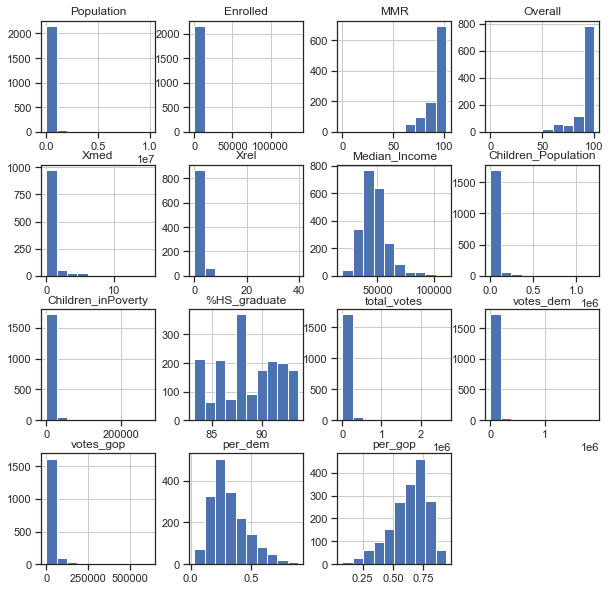

In [31]:
# histograms of numerical value
hist = df.hist(bins=10, figsize=(10,10))

### Reviewing for outliers and anomalies
- Boxplots
    - Quick way to identify outliers or anomalous observations
    - Important to consider these inthe context of the problem

Text(0.5, 1.0, 'Boxplot of each column')

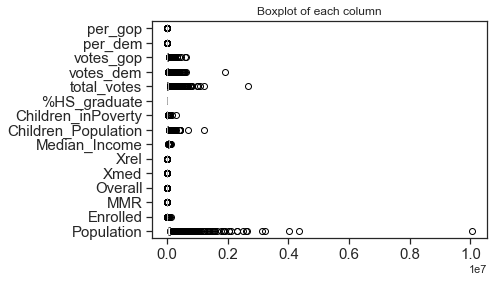

In [32]:
# creating a boxplot for every column in df
boxplot = df.boxplot(grid=False, vert=False, fontsize=15)
title_boxplot = 'Boxplot of each column'
plt.title( title_boxplot )

Text(0.5, 1.0, 'Population and Enrolled')

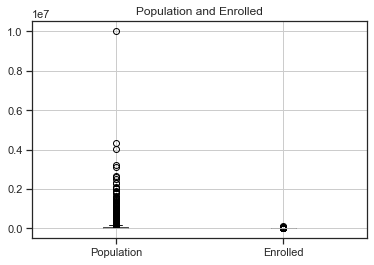

In [33]:
df.boxplot(column=['Population', 'Enrolled'], return_type='axes')
title_boxplot = 'Population and Enrolled'
plt.title( title_boxplot )

Text(0.5, 1.0, 'MMR and overall vaccination')

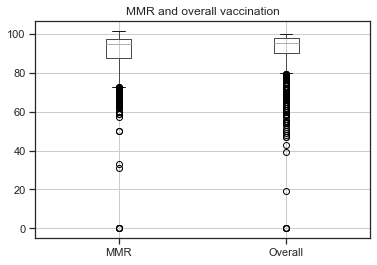

In [34]:
df.boxplot(column=['MMR', 'Overall'], return_type='axes')
title_boxplot = 'MMR and overall vaccination'
plt.title( title_boxplot )

Text(0.5, 1.0, 'Exemption for medical and religion reasons')

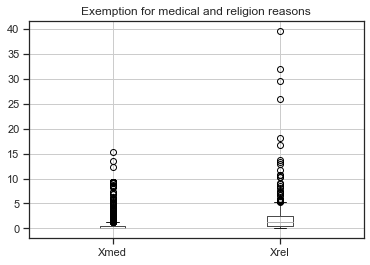

In [35]:
df.boxplot(column=['Xmed', 'Xrel'], return_type='axes')
title_boxplot = 'Exemption for medical and religion reasons'
plt.title( title_boxplot )

Text(0.5, 1.0, 'Children popualtion and children in poverty boxplot')

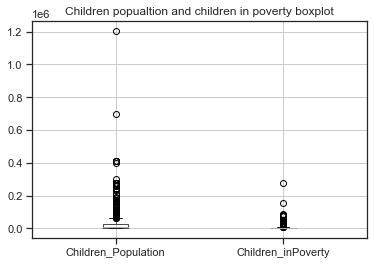

In [36]:
df.boxplot(column=[ 'Children_Population', 'Children_inPoverty'], return_type='axes')
title_boxplot = 'Children popualtion and children in poverty boxplot'
plt.title( title_boxplot )

Text(0.5, 1.0, '% of high school graduates or higher')

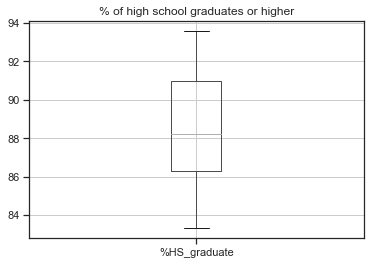

In [37]:
df.boxplot(column=['%HS_graduate'], return_type='axes')
title_boxplot = '% of high school graduates or higher'
plt.title( title_boxplot )

Text(0.5, 1.0, 'Median income')

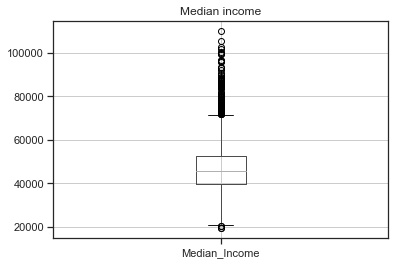

In [38]:
df.boxplot(column=['Median_Income'], return_type='axes')
title_boxplot = 'Median income'
plt.title( title_boxplot )

Text(0.5, 1.0, 'total votes, votes for dems, votes for gop')

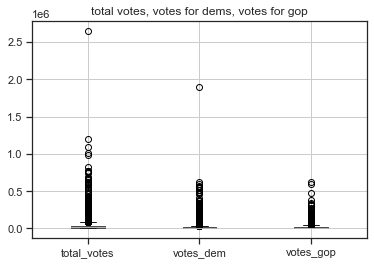

In [39]:
df.boxplot(column=['total_votes', 'votes_dem', 'votes_gop'], return_type='axes')
title_boxplot = 'total votes, votes for dems, votes for gop'
plt.title( title_boxplot )

Text(0.5, 1.0, '% of votes for dems and gops')

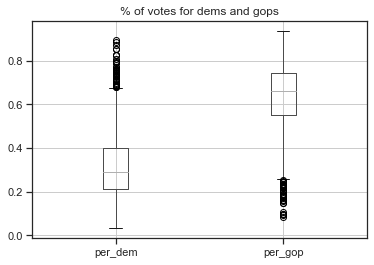

In [40]:
df.boxplot(column=['per_dem', 'per_gop'], return_type='axes')
title_boxplot = '% of votes for dems and gops'
plt.title( title_boxplot )

## Visualizing relationship between variables
- Correlation matrix
    - Look at correlation for each variable in the dataframe
    - Using Pearson correlation heatmap
- Pairplots
    - Visualizing variables distribution against one another

## Correlation Matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'Population'),
  Text(0, 1.5, 'Enrolled'),
  Text(0, 2.5, 'MMR'),
  Text(0, 3.5, 'Overall'),
  Text(0, 4.5, 'Xmed'),
  Text(0, 5.5, 'Xrel'),
  Text(0, 6.5, 'Median_Income'),
  Text(0, 7.5, 'Children_Population'),
  Text(0, 8.5, 'Children_inPoverty'),
  Text(0, 9.5, '%HS_graduate'),
  Text(0, 10.5, 'total_votes'),
  Text(0, 11.5, 'votes_dem'),
  Text(0, 12.5, 'votes_gop'),
  Text(0, 13.5, 'per_dem'),
  Text(0, 14.5, 'per_gop')])

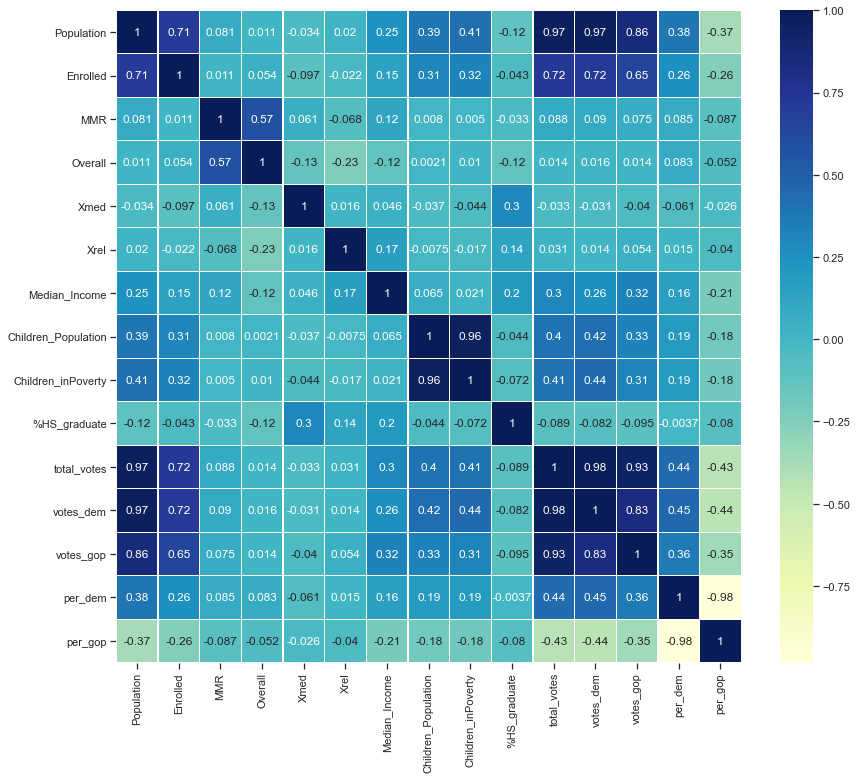

In [41]:
# creating a correlation matrix heat map
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), linewidth=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0)

### Question:

    1. Does the correlation change if I look at subsets of the dataframe? 
        a. Similar school sizes?
        b. Similar median income?
        c. Per political party?

## Pairplots

Another way of evaluating the variables distribution against each other.

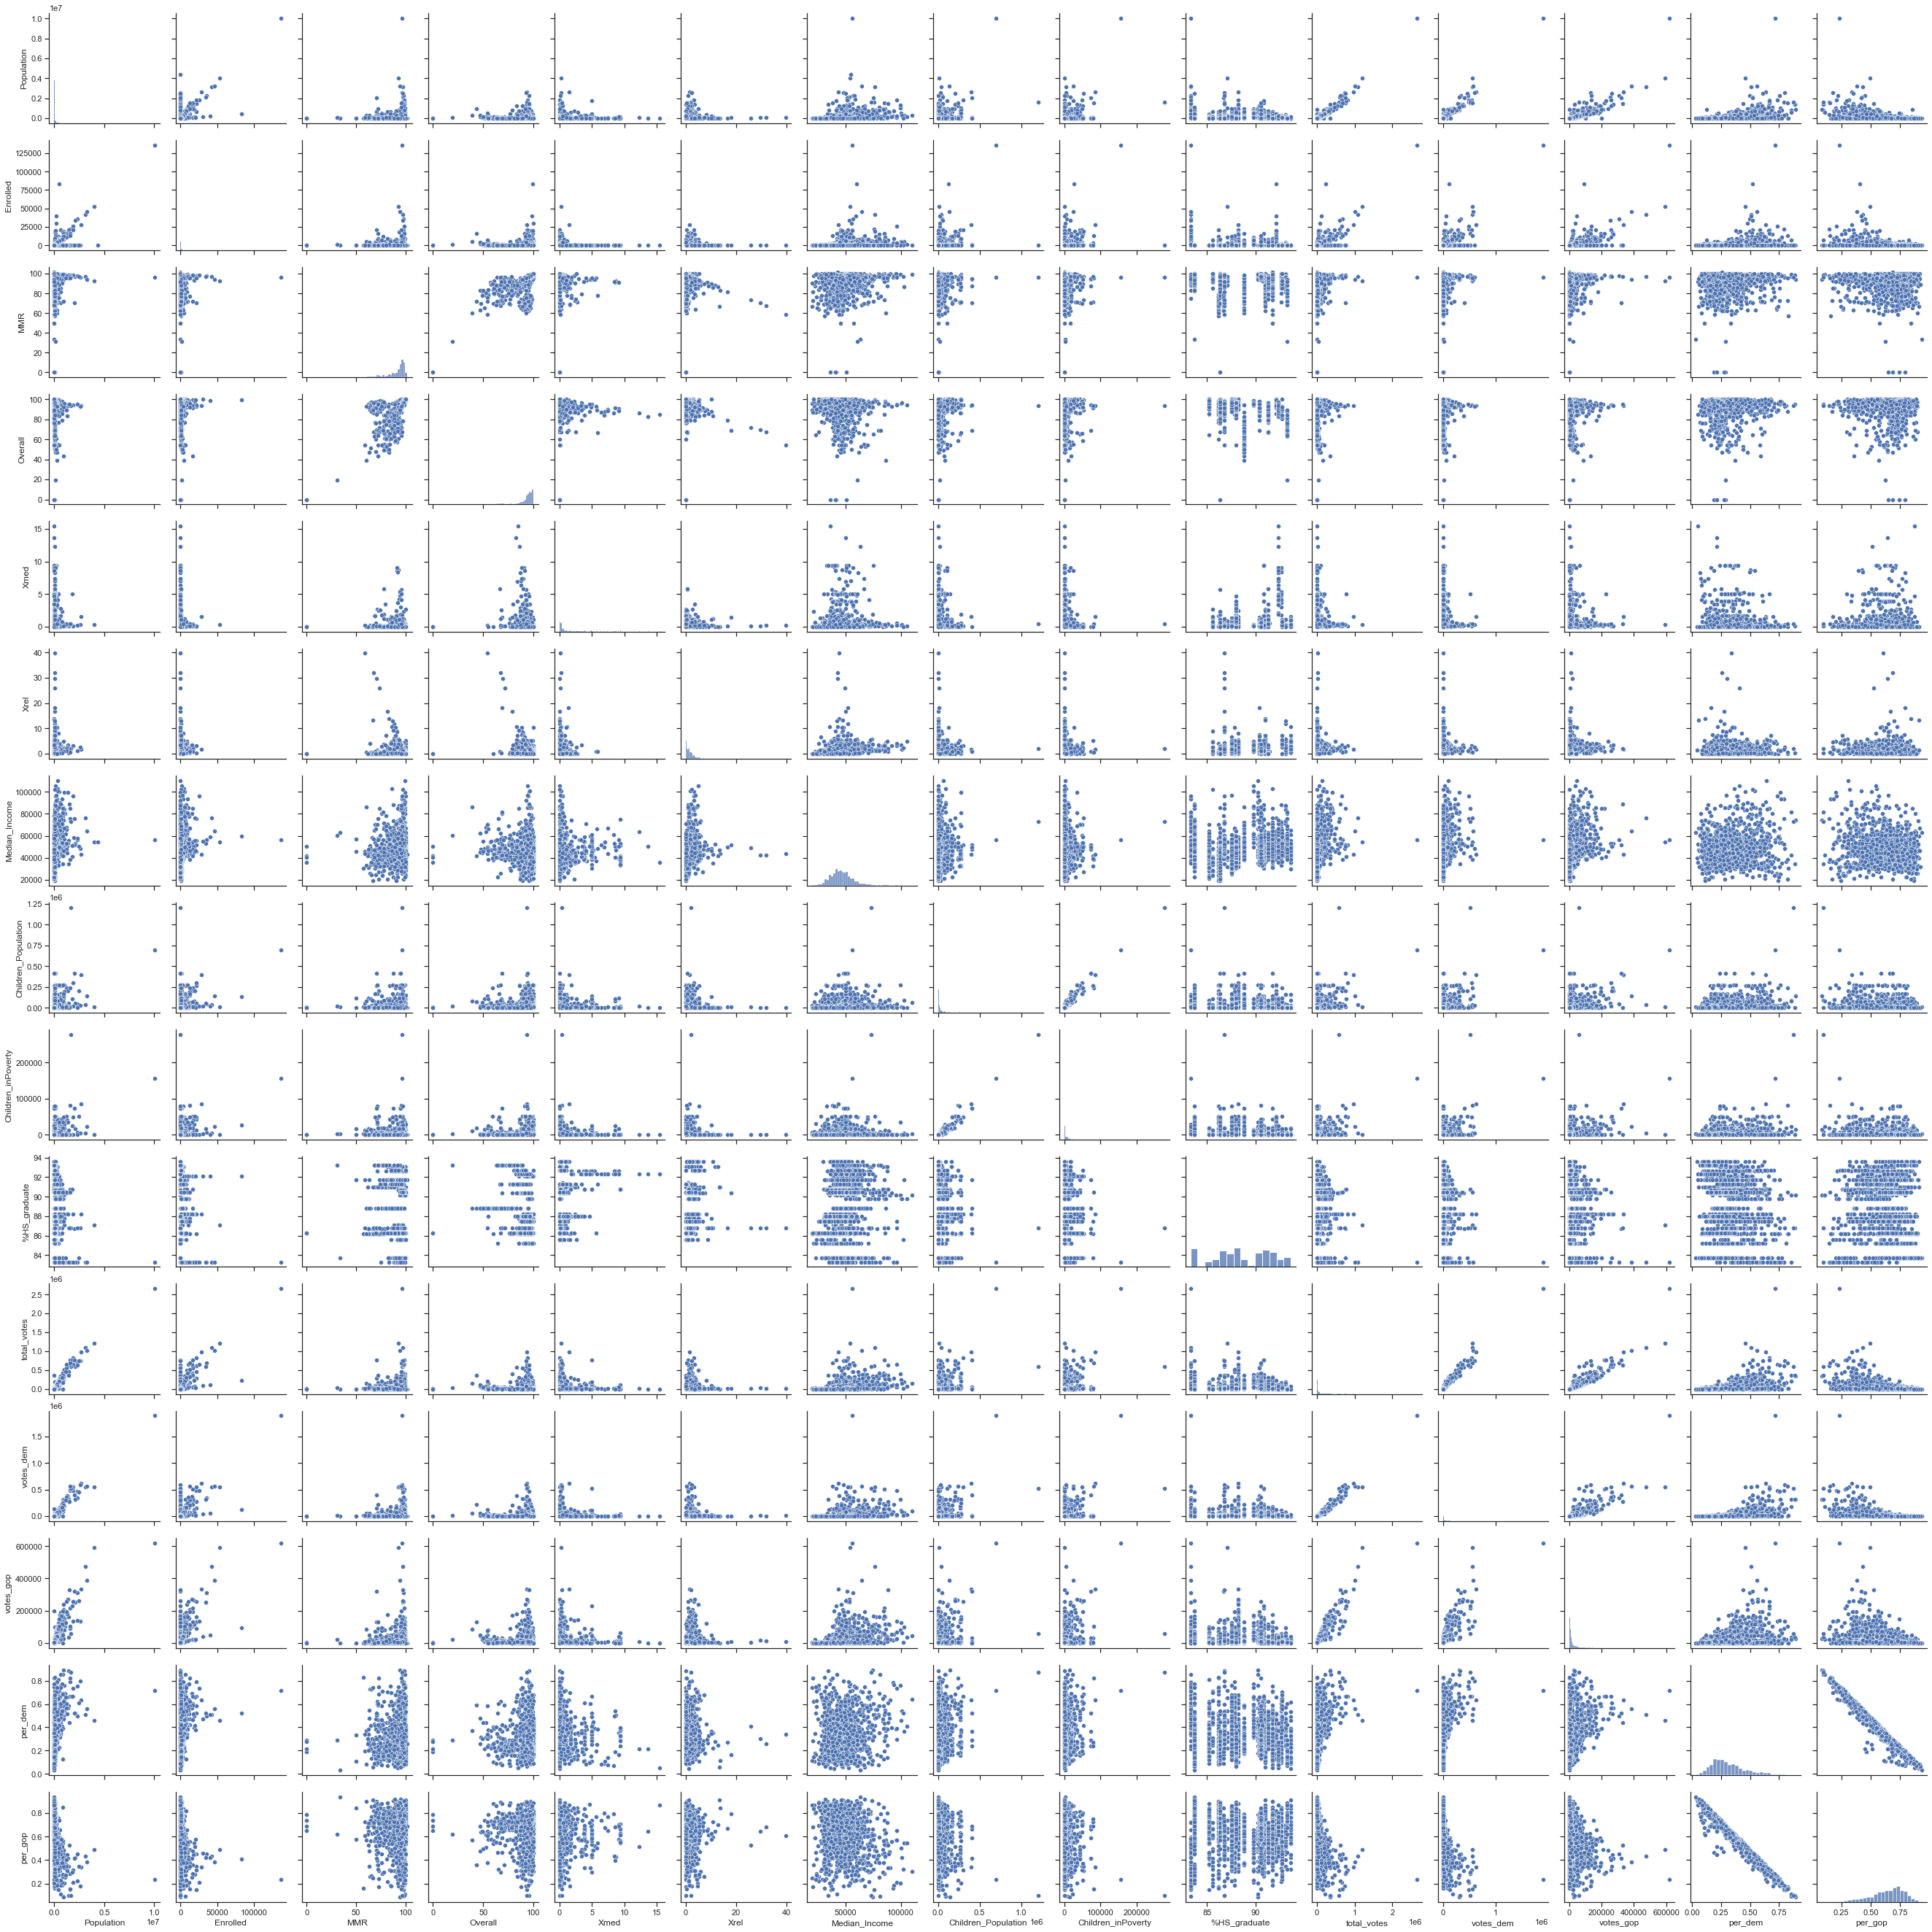

In [42]:
# creating a pair plot for all numeric variables
_ = sns.pairplot(df)

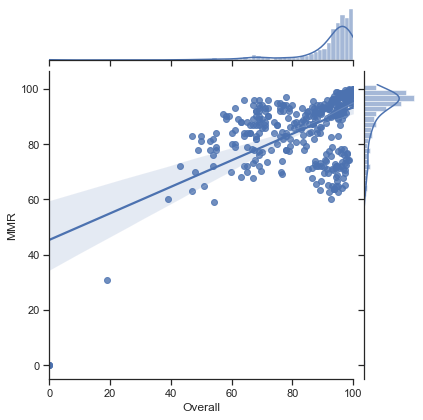

In [43]:
# Further investigation
# visualizing variables of interest
sns.jointplot(x='Overall', y='MMR', data=df, kind="reg");

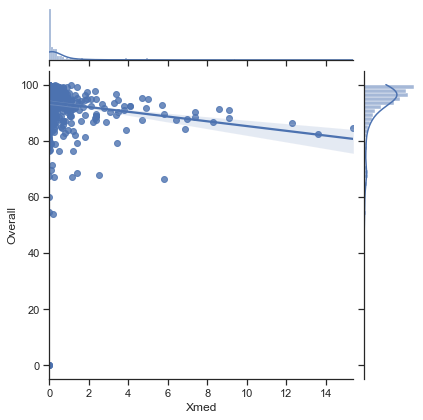

In [44]:
sns.jointplot(x='Xmed', y='Overall', data=df, kind="reg");

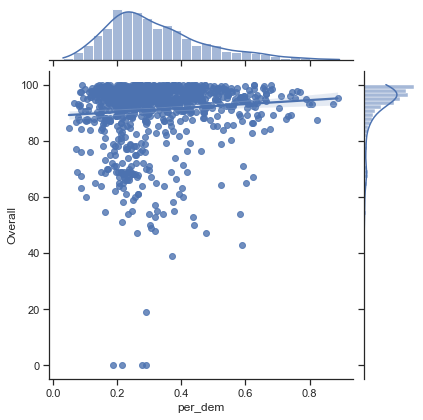

In [45]:
# visualizing variables of interest
sns.jointplot(x='per_dem', y='Overall', data=df, kind="reg");

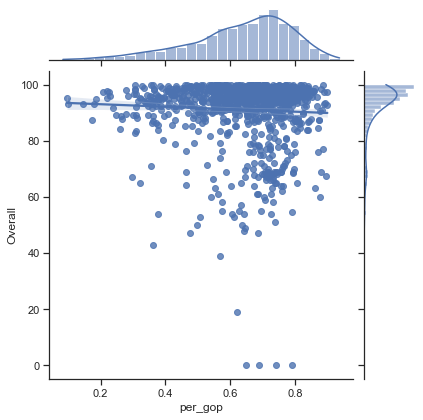

In [46]:
# visualizing variables of interest
sns.jointplot(x='per_gop', y='Overall', data=df, kind="reg");

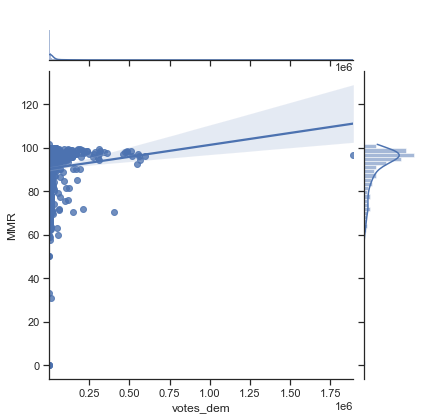

In [47]:
# visualizing variables of interest
sns.jointplot(x='votes_dem', y='MMR', data=df, kind="reg");

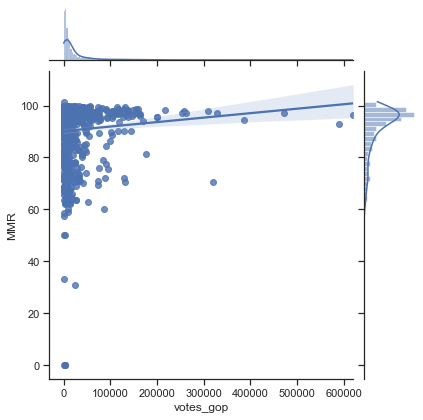

In [48]:
# visualizing variables of interest
sns.jointplot(x='votes_gop', y='MMR', data=df, kind="reg");

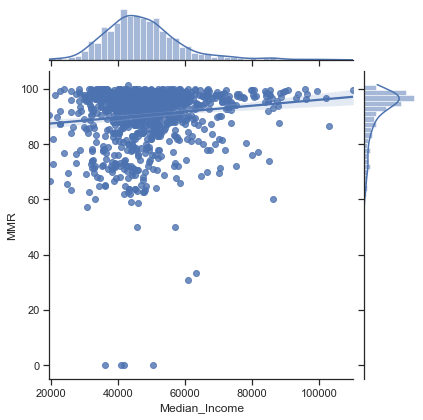

In [49]:
sns.jointplot(x='Median_Income', y='MMR', data=df, kind="reg");

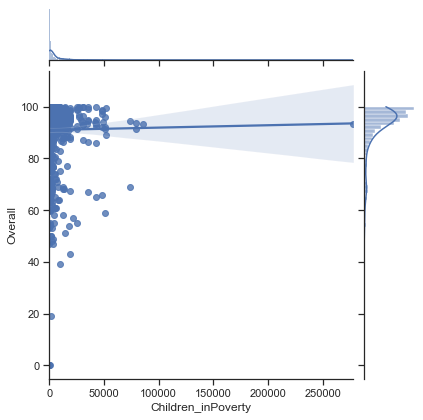

In [50]:
sns.jointplot(x='Children_inPoverty', y='Overall', data=df, kind="reg");

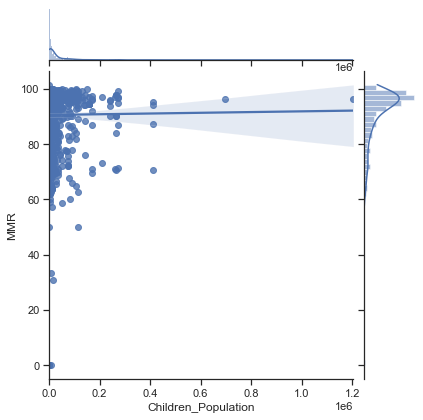

In [51]:
sns.jointplot(x='Children_Population', y='MMR', data=df, kind="reg");

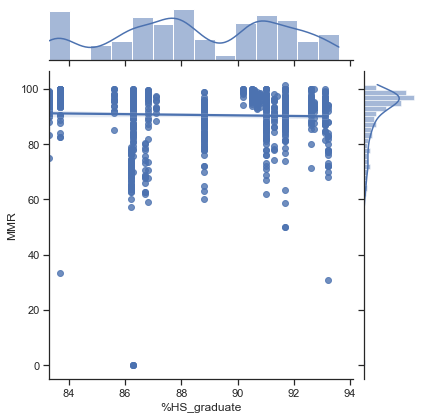

In [52]:
sns.jointplot(x='%HS_graduate', y='MMR', data=df, kind="reg");

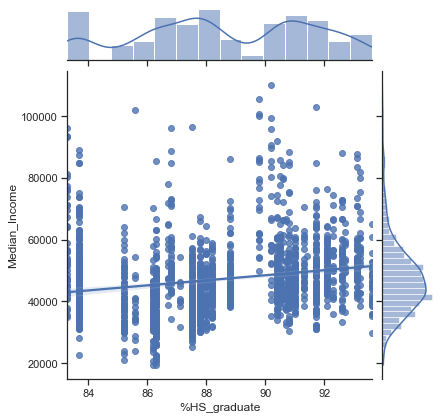

In [53]:
sns.jointplot(x='%HS_graduate', y='Median_Income', data=df, kind="reg");

### Conclusions
The highest predictor of overall vaccination is MMR vaccination. There's a fairly weak positive relationship between median income and MMR vaccination. The relationship between number of votes for democrats and MMR vaccination is stronger than when compared to number of votes for republicans. Overall vaccination show a slight positive correlation when compared to the percentage of votes for democrats and slight negative when compared to the percentage of votes for republicans. Children population, number of children in poverty, and % of high school graduates show no relationship to MMR or Overall vaccination compliance.

### Update

Due to missing data on the dependent variables (~50% missing data), I chose to no longer pursue further investigation for this project at this time.